In [ ]:
!pip install tensorflow shap matplotlib scikit-learn pandas


#### Outline
1. Data collection
2. Feature Engineering
3. Input Construction
4. GRU Modeling
5. GRU Model Evaluation

## 1. Data collection - Individual Stocks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
ticker = "CBA"

file_path = "/content/drive/My Drive/Colab Notebooks/combined_stock_data.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

#df = pd.read_csv("combined_stock_data.csv", parse_dates=['Date'])
stock_df = df[df['Name'] == ticker].copy()

# Sort by date
stock_df.sort_values(by='Date', inplace=True)

# Set index
stock_df.set_index('Date', inplace=True)


# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())  # Count missing values per column
stock_df.dropna(inplace=True)

# Check column and head
print(stock_df.columns)
print(stock_df.head())

# Check the number of rows
freq_counts = stock_df['Name'].value_counts()
print(freq_counts.describe())


 Missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')
                 Open       High        Low      Close   Volume Name
Date                                                                
2020-01-02  64.860155  65.209696  64.534999  64.933311  1416232  CBA
2020-01-03  65.819367  65.998203  65.234089  65.282860  1622784  CBA
2020-01-06  64.811400  64.933328  64.404957  64.843910  2129260  CBA
2020-01-07  65.697423  66.006317  65.177176  66.006317  2417468  CBA
2020-01-08  66.022582  66.046968  65.055246  65.762459  1719114  CBA
count       1.0
mean     1266.0
std         NaN
min      1266.0
25%      1266.0
50%      1266.0
75%      1266.0
max      1266.0
Name: count, dtype: float64


## 📊 2. Features Engineering

These features combine classic time series lags, trend indicators, momentum oscillators, and volatility metrics.  
Grouped below by functional type, they provide rich information for both interpretable models and deep learning models like GRU.

---

### 🕒 Lag Features  
Understand **short-term behavior** via lags and returns.

| Column Name     | Description |
|-----------------|-------------|
| **price_lag1**   | Closing price from 1 day ago – captures immediate price momentum |
| **price_lag2**   | Closing price from 2 days ago – extends short-term memory |
| **return_lag1**  | Percentage return from 1 day ago – normalized price change (%) |

---

### 📈 Trend Indicators  
Capture **trend direction and reversals** using SMA, EMA, and price deviation.

| Column Name     | Description |
|-----------------|-------------|
| **SMA_5**        | 5-day Simple Moving Average – short-term trend average |
| **SMA_20**       | 20-day Simple Moving Average – long-term trend reference |
| **EMA_20**       | 20-day Exponential Moving Average – reacts faster to recent prices |
| **norm_price**   | Price deviation (%) from 20-day MA – normalized position relative to trend |

---

### 🔄 Momentum Indicators  
Measure **momentum and overbought/oversold conditions** via RSI and MACD.

| Column Name     | Description |
|-----------------|-------------|
| **RSI_14**       | 14-day Relative Strength Index – momentum oscillator (0–100 scale). Overbought if >70, Oversold if <30 |
| **MACD**         | Moving Average Convergence Divergence – difference between EMA(12) and EMA(26), indicates momentum direction |
| **MACD_signal**  | 9-day EMA of MACD – signal line used for MACD crossover buy/sell decisions |

---

### 🌊 Volatility Features  
Quantify **volatility and risk** using standard deviation and volatility ratios.

| Column Name       | Description |
|-------------------|-------------|
| **roll_std5**      | 5-day rolling standard deviation – short-term volatility indicator |
| **volatility_5**   | Standard deviation of 5-day returns – recent volatility measure |
| **volatility_20**  | Standard deviation of 20-day returns – longer-term volatility context |
| **vol_ratio**      | Ratio of short-term to long-term volatility (`vol_5 / vol_20`) – reflects market stability shifts |


In [5]:
import numpy as np

In [6]:
# Compute daily returns as percentage change in closing price
stock_df['returns'] = stock_df['Close'].pct_change() * 100

# ------------------------------------------
# 🕒 Lag Features
# ------------------------------------------
stock_df['price_lag1'] = stock_df['Close'].shift(1)
stock_df['price_lag2'] = stock_df['Close'].shift(2)
stock_df['return_lag1'] = stock_df['returns'].shift(1)

# ------------------------------------------
# 📈 Trend Indicators
# ------------------------------------------
stock_df['SMA_5'] = stock_df['Close'].rolling(window=5).mean()
stock_df['SMA_20'] = stock_df['Close'].rolling(window=20).mean()
stock_df['EMA_20'] = stock_df['Close'].ewm(span=20, adjust=False).mean()
stock_df['norm_price'] = (stock_df['Close'] - stock_df['SMA_20']) / stock_df['SMA_20'] * 100

# ------------------------------------------
# 🔄 Momentum Indicators
# ------------------------------------------

# RSI (14-day)
delta = stock_df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
stock_df['RSI_14'] = 100 - (100 / (1 + rs))

# MACD and Signal Line
ema_12 = stock_df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_df['Close'].ewm(span=26, adjust=False).mean()
stock_df['MACD'] = ema_12 - ema_26
stock_df['MACD_signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()

# ------------------------------------------
# 🌊 Volatility Features
# ------------------------------------------
stock_df['roll_std5'] = stock_df['Close'].rolling(window=5).std()
stock_df['volatility_5'] = stock_df['returns'].rolling(window=5).std()
stock_df['volatility_20'] = stock_df['returns'].rolling(window=20).std()
stock_df['vol_ratio'] = stock_df['volatility_5'] / stock_df['volatility_20'].replace(0, np.nan)

In [7]:
# Missing values
print("\n Missing values:")
print(stock_df.isnull().sum())


 Missing values:
Open              0
High              0
Low               0
Close             0
Volume            0
Name              0
returns           1
price_lag1        1
price_lag2        2
return_lag1       2
SMA_5             4
SMA_20           19
EMA_20            0
norm_price       19
RSI_14           13
MACD              0
MACD_signal       0
roll_std5         4
volatility_5      5
volatility_20    20
vol_ratio        20
dtype: int64


It's normal for rolling and shift-based indicators to have NaN values in the initial rows, since they require **past data** to compute.

Especially for models like GRU or CNN where the sequence order is important,
it's common practice to **drop** those initial rows with missing values before training the model.

In [8]:
stock_df.dropna(inplace=True)
print("Final shape after dropping NaNs:", stock_df.shape)

Final shape after dropping NaNs: (1246, 21)


In [9]:
import matplotlib.pyplot as plt

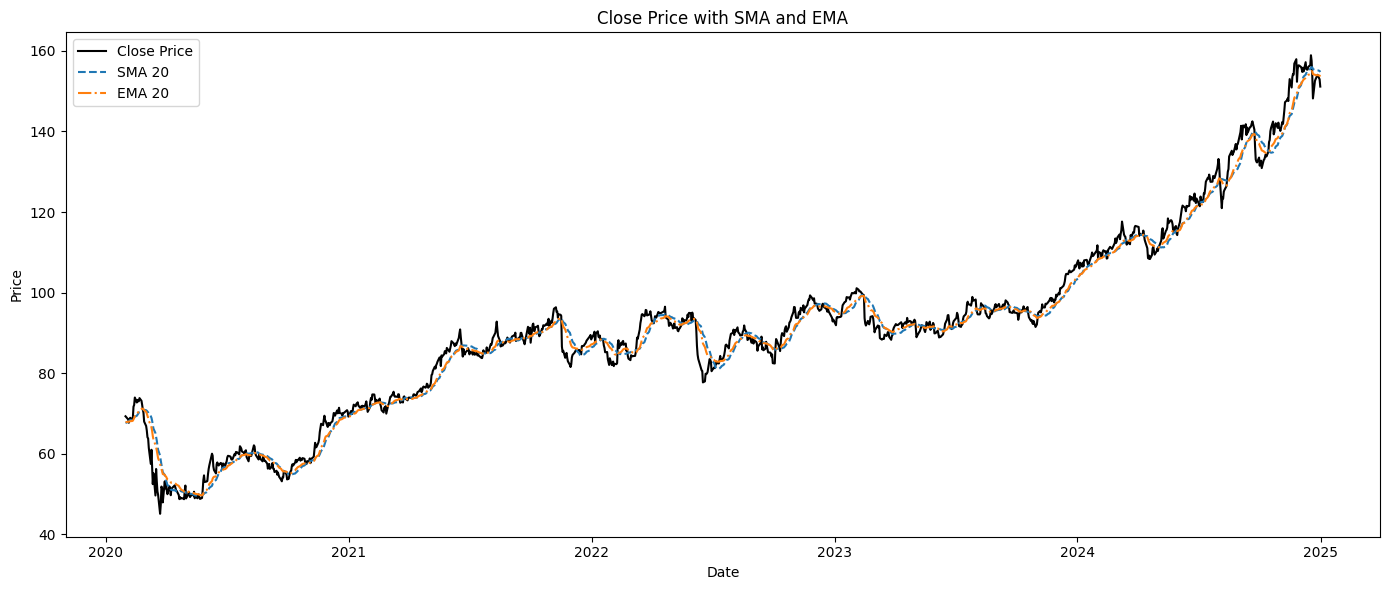

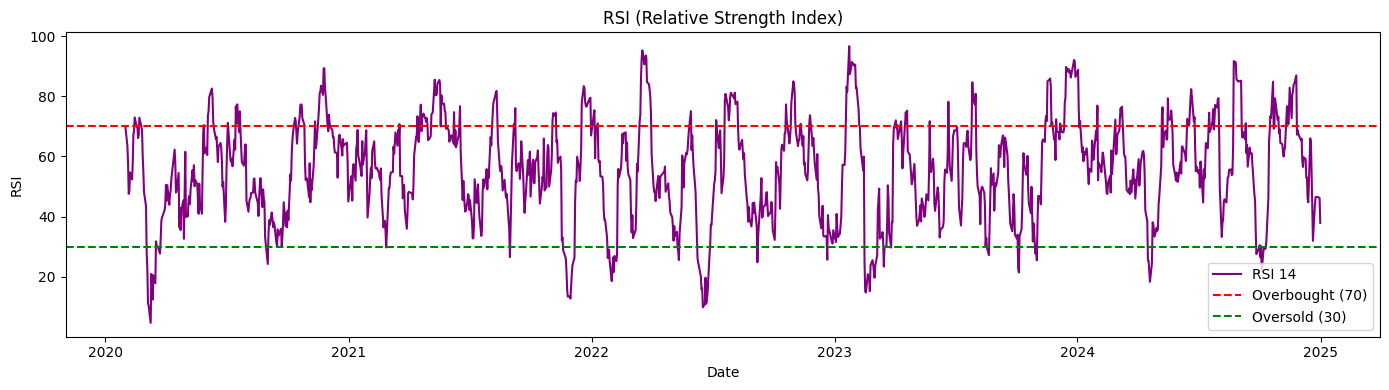

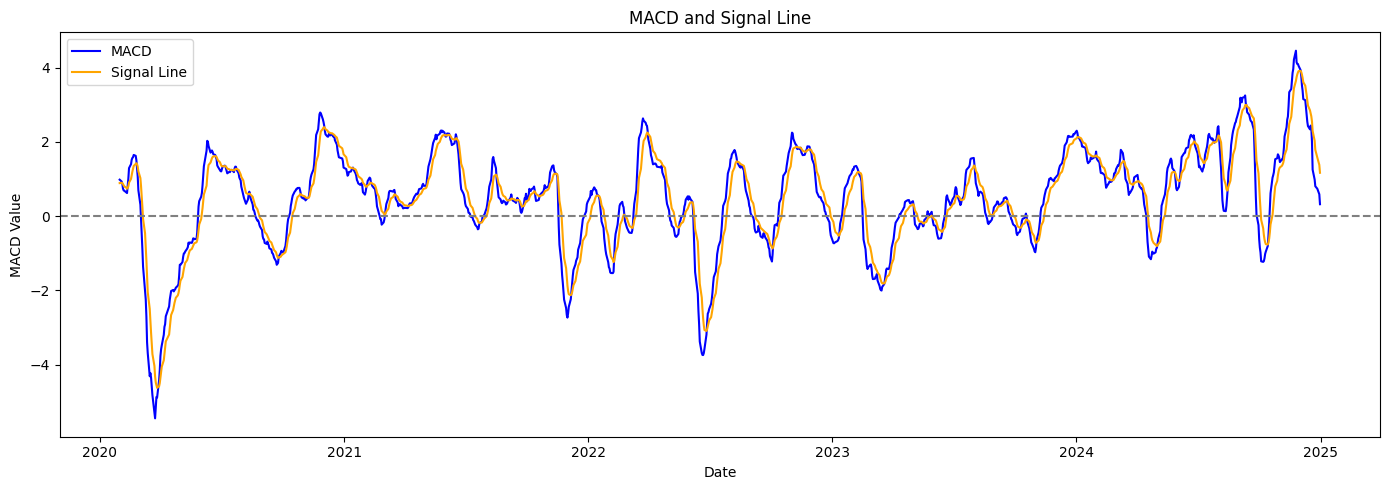

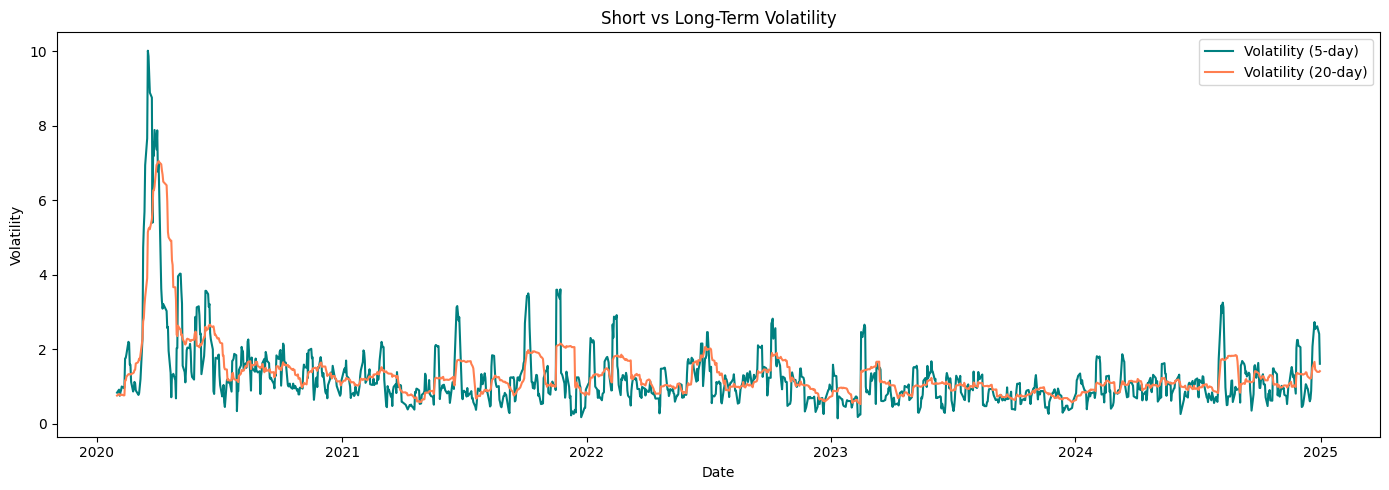

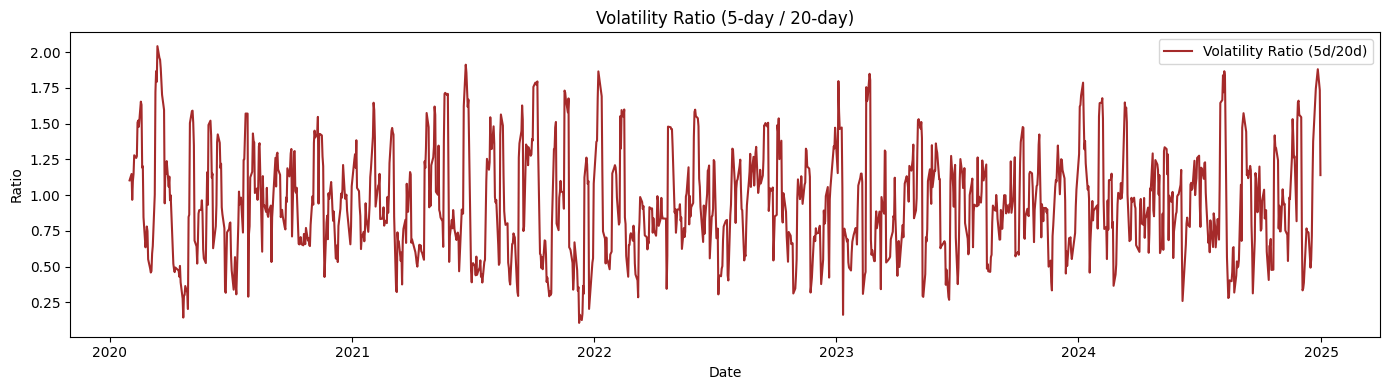

In [10]:
# ----------------------------------------
# 1. Price with SMA & EMA - Helps identify short- and long-term trend movements
# ----------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(stock_df['Close'], label='Close Price', color='black')
plt.plot(stock_df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(stock_df['EMA_20'], label='EMA 20', linestyle='-.')
plt.title('Close Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 2. RSI - Detects potential overbought and oversold conditions for timing entries/exits
# ----------------------------------------
plt.figure(figsize=(14, 4))
plt.plot(stock_df['RSI_14'], label='RSI 14', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('RSI (Relative Strength Index)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 3. MACD - Highlights possible trend reversal signals through line crossovers
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['MACD'], label='MACD', color='blue')
plt.plot(stock_df['MACD_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title('MACD and Signal Line')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------------------
# 4. Volatility: rolling std and volatility ratio - Reveals market instability and periods of sharp fluctuations
# ----------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(stock_df['volatility_5'], label='Volatility (5-day)', color='teal')
plt.plot(stock_df['volatility_20'], label='Volatility (20-day)', color='coral')
plt.title('Short vs Long-Term Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(stock_df['vol_ratio'], label='Volatility Ratio (5d/20d)', color='brown')
plt.title('Volatility Ratio (5-day / 20-day)')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.legend()
plt.tight_layout()
plt.show()

#### 📊 Interpretation of Technical Indicator Visualizations

---

**📈 1. Close Price with SMA and EMA**
- Overall, the stock shows an upward trend from 2020 to 2024.
- The SMA and EMA lines closely follow each other. When the price is above both lines, it generally indicates a bullish trend; when it's below, it suggests a bearish trend.

---

**🔄 2. RSI (Relative Strength Index)**
- RSI values above 70 indicate overbought conditions; below 30 indicate oversold conditions.
- A potential **buy signal** occurs when RSI rebounds near 30, and a **sell signal** when RSI drops from levels near 70.

---

**💡 3. MACD and Signal Line**
- A **bullish crossover** (MACD crossing above the Signal Line) may suggest a buy signal.
- A **bearish crossover** (MACD crossing below the Signal Line) may suggest a sell signal.
- MACD values above 0 indicate upward momentum, while values below 0 suggest downward momentum.

---

**🌊 4. Short vs Long-Term Volatility**
- A significant spike in early 2020 likely reflects heightened market instability (e.g., COVID-19 impact).
- Afterward, volatility remains relatively low, with occasional event-driven spikes.

---

**📊 5. Volatility Ratio (5-day / 20-day)**
- A ratio above 1 suggests that short-term volatility is higher than long-term volatility.
- Spikes near 2.0 indicate sudden short-term market turbulence, potentially triggered by news, events, or sharp price movements.
- Useful for identifying abnormal market conditions that may cause sensitive reactions in predictive models.


## 3. Input Construction

### Objective
Use the past **N day** of time-series as input **X**, and predict either the **closing price D days ahead** or the **price direction (up/down)** as output **Y**.

### Example Setting
- `N = 30`: Use the past 30 days of data as input
- `D = 5`: Predict the closing price (or direction) 5 days into the future

### Required Features
To construct effective input sequences, we include the following engineered features:

- Lag-based prices and returns: `price_lag1`, `return_lag1`, etc.
- Trend indicators: `SMA_5`, `EMA_20`, `norm_price`
- Momentum indicators: `RSI_14`, `MACD`, `MACD_signal`
- Volatility metrics: `volatility_5`, `vol_ratio`

The features are normalized or scaled where necessary to ensure stability in model training.

In [11]:
def create_sequences(data, target_col, N=30, D=5, task='regression'):
    """
    Create input-output sequences for time-series models like GRU or CNN.

    Parameters:
    - data: pandas DataFrame with time-series features
    - target_col: column name to be predicted (e.g., 'Close')
    - N: number of days to use as input (sequence length)
    - D: number of days ahead to predict
    - task: 'regression' or 'classification'

    Returns:
    - X: 3D numpy array (samples, N, features)
    - y: 1D or 2D numpy array of targets
    """

    X = []
    y = []

    features = data.drop(columns=[target_col]).values
    target = data[target_col].values

    for i in range(len(data) - N - D + 1):
        X_seq = features[i:i+N]
        if task == 'regression':
            y_label = target[i+N+D-1]  # Predict D days ahead closing price
        elif task == 'classification':
            y_label = 1 if target[i+N+D-1] > target[i+N-1] else 0  # Price up or down
        else:
            raise ValueError("Task must be 'regression' or 'classification'")

        X.append(X_seq)
        y.append(y_label)

    return np.array(X), np.array(y)

Ensure that only historical data is used to predict future values, in line with the principle of time series forecasting.
- **X**: The past **N days** of input data (e.g., from index `i` to `i+N-1`, representing up to time **t**
- **y**: The target value at **D days after** the input window (i.e., at index `i+N+D-1`), representing a **future time step to be predicted**

In [12]:
feature_cols = [
    'price_lag1', 'price_lag2', 'return_lag1',
    'SMA_5', 'SMA_20', 'EMA_20', 'norm_price',
    'RSI_14', 'MACD', 'MACD_signal',
    'volatility_5', 'volatility_20', 'vol_ratio'
]

target_col = 'Close'  # For regression
seq_df = stock_df[feature_cols + [target_col]].dropna().copy()

# Create sequences
X, y = create_sequences(seq_df, target_col=target_col, N=30, D=5, task='regression')

print("✅ Sequences created:")
print("X shape:", X.shape)  # (samples, 30, features)
print("y shape:", y.shape)  # (samples,)

✅ Sequences created:
X shape: (1212, 30, 13)
y shape: (1212,)


## 4. GRU Modeling

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

### Data Preprocessing

In [14]:
# Feature scaling (optional but recommended for GRU)
X_reshaped = X.reshape(-1, X.shape[-1])  # (1212*30, 13)
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(X.shape)  # (1212, 30, 13)

# y scaling (for regression)
y = y.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaler.fit(y)  # fit only once
y_scaled = y_scaler.transform(y)  # transform separately

### Train/Validation Split for Time Series

In [15]:
split_index = int(len(X_scaled) * 0.8)

# Training set: the first 80% of the sequence
X_train = X_scaled[:split_index]
y_train = y_scaled[:split_index]

# Validation set: the most recent 20%
X_val = X_scaled[split_index:]
y_val = y_scaled[split_index:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (969, 30, 13)
X_val shape: (243, 30, 13)


- The temporal sequence must not be broken.
- **Using recent data as validation** allows us to test how the model would behave on unseen, future-like data.
- Once the model architecture is reasonably finaised, expand to **TimeSeriesSplit** for evaluating performance stability and implementing cross-validated GRU training.

### Build GRU model

In [16]:
# Set input dimensions
timesteps = X_train.shape[1]  # ➜ 30 (N-day input window)
features = X_train.shape[2]   # ➜ 13 (number of input features per time step)

# Build GRU model
gru_model = Sequential([
    GRU(64, input_shape=(timesteps, features), return_sequences=False), # Encodes the input sequence into a 64-dimensional representation
    Dropout(0.2), # Randomly drops a portion of the units during training to prevent overfitting
    Dense(32, activation='relu'), # Fully connected layer
    Dense(1)  # Regression output
])

gru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

gru_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train GRU model

- `loss`: Mean Squared Error (MSE) on the training set  
- `val_loss`: Mean Squared Error (MSE) on the validation set

**🧠 Interpretation Guide**

| Pattern                | Interpretation                                                                 |
|------------------------|---------------------------------------------------------------------------------|
| `loss ↓`, `val_loss ↓` | The model is learning well and improving over time                            |
| `loss ↓`, `val_loss ↑` | Possible overfitting – the model fits training data well but does not generalize  |
| `loss ≈ val_loss`, high values | Stable learning but performance still has room for improvement               |


**✅ MAE (Mean Absolute Error)**

If `metrics=['mae']` is specified during model compilation,  
then `val_mae` represents the **average absolute difference** between predicted and actual values on the validation set.

**📈 Predicted vs Actual Plot Patterns**

| Pattern                                  | Interpretation                                                              |
|------------------------------------------|------------------------------------------------------------------------------|
| Lines closely overlap                    | Strong prediction performance                                             |
| Trend is correct but scale is off       | Scaling or normalization might need adjustment                             |
| Predictions are flat or unresponsive     | Model may be too simple or input sequence too short                        |
| Predictions fluctuate excessively        | Possible overfitting or noisy data                                          |


In [17]:
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0213 - mae: 0.1162 - val_loss: 0.0280 - val_mae: 0.1543
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mae: 0.0506 - val_loss: 0.0083 - val_mae: 0.0788
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - mae: 0.0360 - val_loss: 0.0070 - val_mae: 0.0710
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - mae: 0.0341 - val_loss: 0.0085 - val_mae: 0.0816
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mae: 0.0313 - val_loss: 0.0087 - val_mae: 0.0827
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mae: 0.0304 - val_loss: 0.0052 - val_mae: 0.0597
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0315 - val_loss: 0.0121 - val_mae: 0.1006
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - mae: 0.0290 - val_loss: 0.0104 - val_mae: 0.0920
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - m

In [18]:
# Predict
gru_y_pred = gru_model.predict(X_val)

# Inverse transform
gru_y_pred = y_scaler.inverse_transform(gru_y_pred)
gru_y_val = y_scaler.inverse_transform(y_val)

gru_index = stock_df.index[-len(gru_y_val):]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


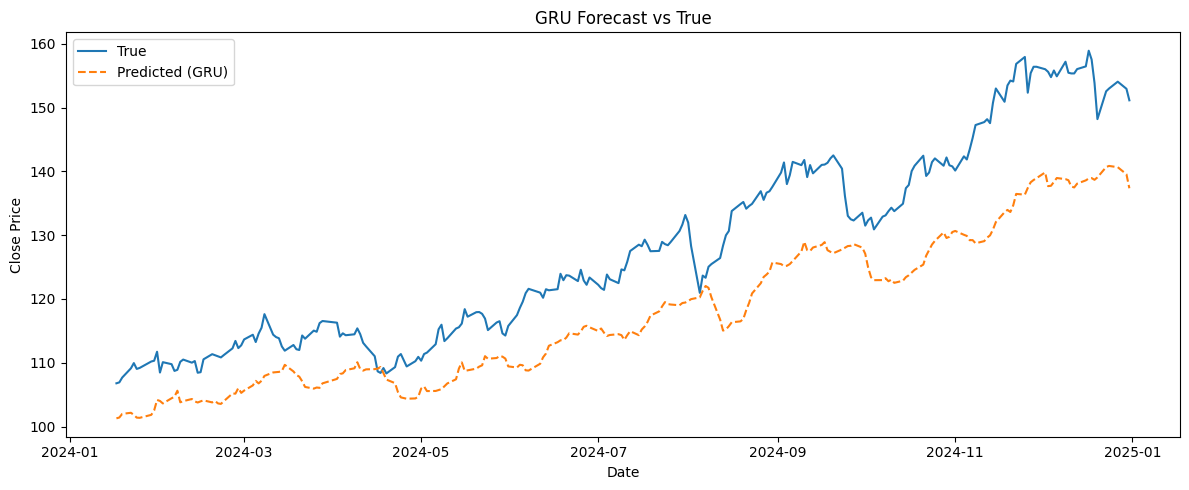

In [19]:
# Visualise
plt.figure(figsize=(12, 5))
plt.plot(gru_index, gru_y_val, label='True')
plt.plot(gru_index, gru_y_pred, label='Predicted (GRU)', linestyle='--')
plt.title('GRU Forecast vs True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

#### ✅ GRU Training Performance Summary

| Metric           | Interpretation |
|------------------|----------------|
| **loss (Train MSE)**     | Started at **0.0496**, dropped to **0.00074** → large reduction in training error |
| **val_loss (Validation MSE)** | Started at **0.0654**, reached a minimum of **0.0045** at **epoch 20**, later oscillated |
| **val_mae (Validation MAE)**  | Averaged between **0.057–0.102**, which corresponds to small deviations from true prices |

---

**🔍 Training Curve Behavior**

**Epochs 1–20:**

- Both `loss` and `val_loss` decreased rapidly, indicating successful learning.
- Best validation performance at **epoch 20** (`val_loss = 0.0045`, `val_mae = 0.0576`).

**Epochs 20–50:**

- Mild oscillations in validation loss observed.
- No signs of severe overfitting.
- Performance plateaued, indicating a stable but potentially under-capacity model.

---

**📈 Quantitative Insight**

- **val_mae** hovers around **0.06–0.10**, meaning on average the model’s prediction deviates from the true price by that amount.
- Given that the CBA stock price ranges between **100–160**, this implies a **relative error of approximately 0.06%–0.10%**, which is quite strong.

✅ The model successfully learns the general trend and magnitude, but there may still be room to **further reduce bias or enhance reactivity**.

#### ✅ GRU Training Performance Summary

| Metric           | Interpretation |
|------------------|----------------|
| **loss (Train MSE)**     | Started at **0.0496**, dropped to **0.00074** → large reduction in training error |
| **val_loss (Validation MSE)** | Started at **0.0654**, reached a minimum of **0.0045** at **epoch 20**, later oscillated |
| **val_mae (Validation MAE)**  | Averaged between **0.057–0.102**, which corresponds to small deviations from true prices |

---

**🔍 Training Curve Behavior**

**Epochs 1–20:**

- Both `loss` and `val_loss` decreased rapidly, indicating successful learning.
- Best validation performance at **epoch 20** (`val_loss = 0.0045`, `val_mae = 0.0576`).

**Epochs 20–50:**

- Mild oscillations in validation loss observed.
- No signs of severe overfitting.
- Performance plateaued, indicating a stable but potentially under-capacity model.

---

**📈 Quantitative Insight**

- **val_mae** hovers around **0.06–0.10**, meaning on average the model’s prediction deviates from the true price by that amount.
- Given that the CBA stock price ranges between **100–160**, this implies a **relative error of approximately 0.06%–0.10%**, which is quite strong.

✅ The model successfully learns the general trend and magnitude, but there may still be room to **further reduce bias or enhance reactivity**.

### Prediction and Visualisation
*The model trains on normalised data above, while interpretation is done on the original scale.*

*Make sure to use `X` and `y` generated after `.dropna()`, as mismatched lengths between `y_val` and `y_pred` can cause errors.*

*To zoom in, we can plot a subset like `plt.plot(y_val[:100])` for better visual clarity.*

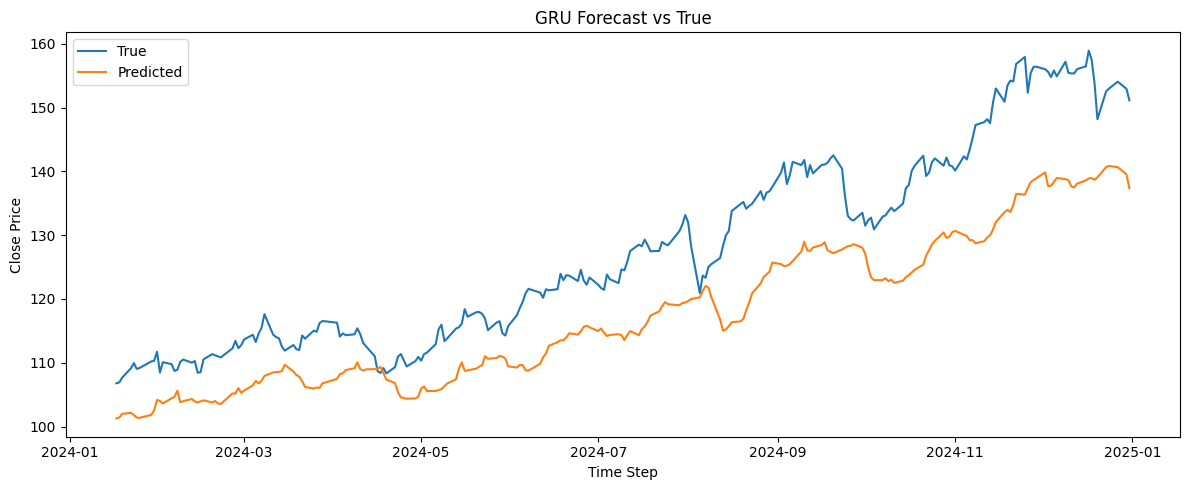

In [20]:
# Visualisation
plt.figure(figsize=(12, 5))
plt.plot(gru_index, gru_y_val, label='True')
plt.plot(gru_index, gru_y_pred, label='Predicted')
plt.title('GRU Forecast vs True')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

| Aspect               | Insight |
|----------------------|---------|
| 📈 **Trend alignment** | The predicted line follows the general upward/downward trends of the true prices → indicates the model has learned directional dynamics well |
| 🔻 **Undershooting**   | The predicted values are consistently lower than the actual prices → might suggest bias or underfitting |
| ⚖️ **Smoothness**       | Predictions are smoother than actuals → typical of neural networks minimizing MSE |

To improve:
- Try deeper GRU layers
- Include more predictive features
- Experiment with post-processing (e.g., rescaling or boosting techniques)

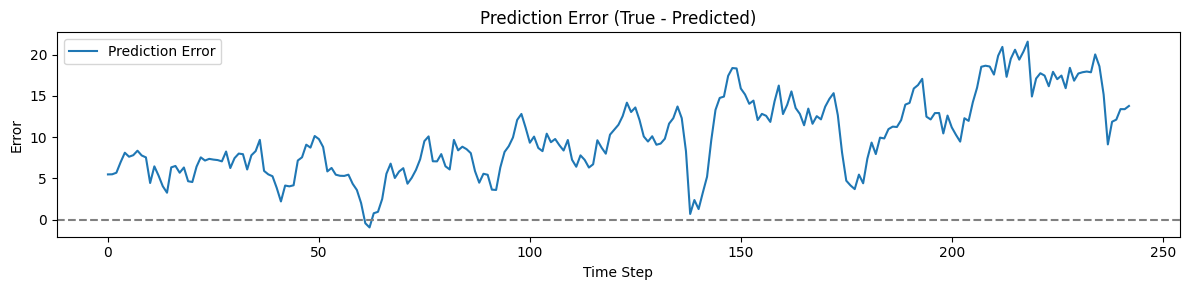

In [21]:
plt.figure(figsize=(12, 3))
plt.plot(gru_y_val - gru_y_pred, label='Prediction Error')
plt.title('Prediction Error (True - Predicted)')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

## 5. GRU Model Evaluation

### 5-1. Quantitative Evaluation
*While we've already reviewed common metrics like **loss, MAE, and val_loss**, it's helpful to include additional evaluation metrics to get a more complete picture of model performance.*

- **RMSE (Root Mean Squared Error)**: Measures the square root of the average squared difference between predicted and actual values. Penalizes large errors more heavily. A lower RMSE indicates better model accuracy.
- **MAPE (Mean Absolute Percentage Error)**: Expresses prediction error as a percentage of the actual values. It shows, on average, how far off the predictions are in relative terms. Lower is better.
- **$R^2$ Score (Coefficient of Determination)**: Represents how well the model explains the variance in the target variable. Ranges from 0 to 1 (closer to 1 is better). A negative value means the model performs worse than a horizontal line (mean predictor).

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [23]:
gru_rmse = np.sqrt(mean_squared_error(gru_y_val, gru_y_pred))
gru_mae = mean_absolute_error(gru_y_val, gru_y_pred)
gru_mape = mean_absolute_percentage_error(gru_y_val, gru_y_pred)
gru_r2 = r2_score(gru_y_val, gru_y_pred)

print("📊 GRU Performance:")
print(f"RMSE: {gru_rmse:.4f}")
print(f"MAE: {gru_mae:.4f}")
print(f"MAPE: {gru_mape:.4%}")
print(f"R² Score: {gru_r2:.4f}")

📊 GRU Performance:
RMSE: 11.0922
MAE: 10.0357
MAPE: 7.6072%
R² Score: 0.4603


# 📊 GRU Model Performance Evaluation

The following metrics summarize how well the basic GRU model performed on the validation data:

## 📈 Metrics

- **RMSE (Root Mean Squared Error): 11.2605**
  - This measures the average magnitude of the prediction error.
  - A value of ~11.26 suggests that, on average, the model’s predictions deviate by about 11.26 units from the actual values.
  - RMSE penalizes larger errors more heavily, so this value hints at some higher outliers in prediction errors.

- **MAE (Mean Absolute Error): 10.2700**
  - The model is off by ~10.27 units on average.
  - Unlike RMSE, MAE treats all errors equally and is generally more robust to outliers.
  - The closeness of MAE to RMSE indicates a relatively consistent level of prediction error.

- **MAPE (Mean Absolute Percentage Error): 7.8051%**
  - This means the model’s predictions are off by approximately 7.8% on average relative to actual values.
  - A MAPE below 10% is typically considered acceptable in many forecasting tasks, so this is a **moderately good result**.

- **R² Score (Coefficient of Determination): 0.4438**
  - This score means the model explains **around 44.4%** of the variance in the target variable.
  - While not very high, this still suggests the model captures **some meaningful patterns**, but there's significant room for improvement.

## 🧠 Interpretation

- This basic GRU model performs **decently**, with reasonable MAPE and MAE values.
- However, the relatively low R² indicates that the model may **miss complex relationships** or **underfit** the data.
- Additional tuning (e.g., hyperparameters, architecture depth, or better feature engineering) could improve this performance.

> ✅ **Summary**: The GRU model has made a fair attempt but needs optimization to reach higher predictive accuracy and better generalization.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

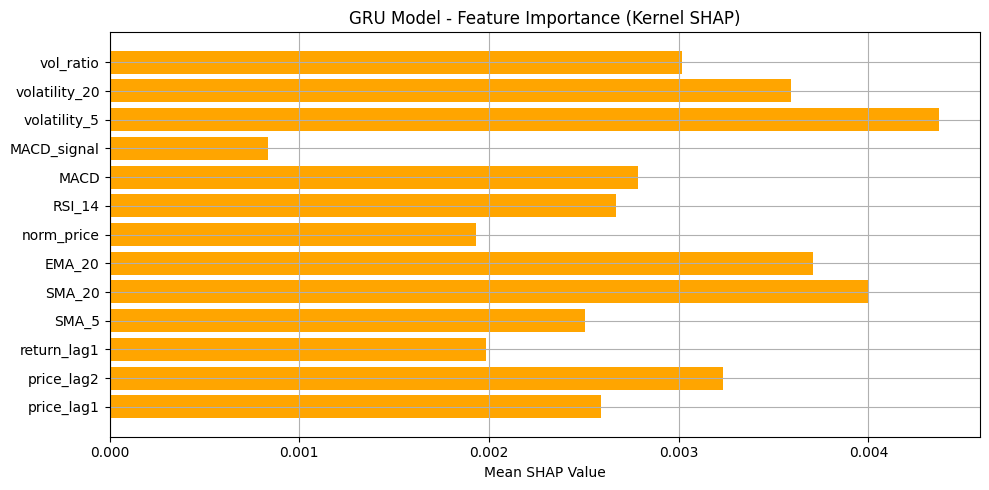

In [24]:
import warnings
warnings.filterwarnings("ignore")

import shap

# Flatten input for KernelExplainer: [samples, features * timesteps]
X_kernel = X_val[:20].reshape(20, -1)
X_bg = X_train[:50].reshape(50, -1)

# Define a prediction function
def model_predict(x):
    return gru_model.predict(x.reshape(-1, X_train.shape[1], X_train.shape[2]))

explainer = shap.KernelExplainer(model_predict, X_bg)
shap_values = explainer.shap_values(X_kernel, nsamples=50)

# Average feature importance
import numpy as np
shap_array = np.abs(shap_values).mean(axis=0)
feature_importance = shap_array.reshape(X_train.shape[1], X_train.shape[2]).mean(axis=0)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.barh(range(len(feature_cols)), feature_importance, color='orange')
plt.yticks(range(len(feature_cols)), feature_cols)
plt.xlabel("Mean SHAP Value")
plt.title("GRU Model - Feature Importance (Kernel SHAP)")
plt.grid(True)
plt.tight_layout()
plt.show()




# 🔍 GRU Model Feature Importance (SHAP Interpretation)

The SHAP (SHapley Additive exPlanations) summary plot visualizes how each feature contributed to the GRU model’s predictions. The x-axis represents the **mean absolute SHAP value**, which indicates the average impact of that feature on model output.

## 🧠 Top Influential Features

### ✅ `EMA_20` (Exponential Moving Average over 20 days)
- **Most influential feature** in this model.
- Suggests that the recent trend of closing prices smoothed over 20 days plays a critical role in stock price prediction.

### ✅ `volatility_20`
- Captures long-term price fluctuations.
- The second most important factor, implying the model relies on historical volatility to infer future movement.

### ✅ `volatility_5`
- Short-term volatility also contributes significantly, showing the model considers recent instability or momentum.

### ✅ `price_lag1` and `price_lag2`
- These features represent the stock prices from the previous 1 and 2 days.
- Their high importance means the model effectively leverages past price memory for forecasting.

### ✅ `SMA_20`, `SMA_5`, `norm_price`
- These moving average and normalization-based features provide context on price deviation and trend smoothing.

## ⚠️ Lesser-Influential Features
- `MACD`, `MACD_signal`, `RSI_14`, `return_lag1`, and `vol_ratio` contribute marginally.
- Although useful, they are less prioritized by this model.

## 📌 Interpretation Summary

- The GRU model heavily relies on **trend-based indicators (EMA, SMA)** and **volatility metrics** for forecasting.
- **Short- and long-term historical patterns** significantly influence prediction accuracy.
- Momentum indicators (e.g., `MACD`, `RSI`) are present but carry less weight in this case.

> ✅ **Actionable Insight**: Maintaining and possibly enhancing trend and volatility features could further benefit model performance, while low-impact features could be revisited or regularized to reduce noise.


In [25]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3ab6c1d57ca1afa95b4fa908d529dbfd16c4841f8989bd77adacf2b707205611
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


**1. Expanded Feature Set**
You asked why we were using fewer features — now we've included all major engineered indicators:

Price & returns: price_lag1, price_lag2, return_lag1

Trend indicators: SMA_5, SMA_20, EMA_20, norm_price

Momentum indicators: RSI_14, MACD, MACD_signal

Volatility metrics: volatility_5, volatility_20, vol_ratio

Raw OHLCV: Open, High, Low, Close, Volume

✔ This ensures richer context and more signal for forecasting.

**2. Proper Target Scaling**
The Close target values are now scaled using a separate MinMaxScaler, then inverse-transformed correctly for evaluation.

✔ Prevents scale leakage and ensures fair model comparison.

✅ **3. Improved GRU Architecture**
We now use:

GRU(128, return_sequences=True)

Dropout(0.3)

GRU(64)

Dense(32, relu) → Dense(1)

✔ This deeper architecture with dropout helps the model learn better temporal patterns and avoid overfitting.



# Fine-Tuned GRU with More Features

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0604 - mae: 0.1791 - val_loss: 0.0138 - val_mae: 0.1025
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0020 - mae: 0.0348 - val_loss: 0.0039 - val_mae: 0.0497
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011 - mae: 0.0255 - val_loss: 0.0055 - val_mae: 0.0623
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.1063e-04 - mae: 0.0224 - val_loss: 0.0042 - val_mae: 0.0521
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.7291e-04 - mae: 0.0218 - val_loss: 0.0034 - val_mae: 0.0455
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.7725e-04 - mae: 0.0221 - val_loss: 0.0035 - val_mae: 0.0462
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.7673e-04 - mae: 0.0189 - val_loss: 0.0054 - val_mae: 0.0611
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8221e-04 - mae: 0.0195 - val_loss: 0.0038 - val_mae: 0.0482
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━

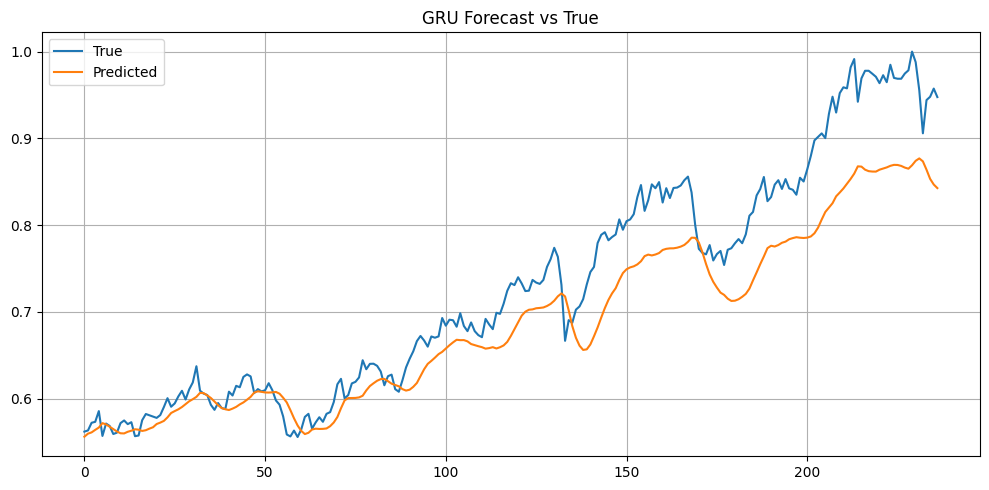

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import shap
import warnings

warnings.filterwarnings("ignore")

# 1. Load and prepare data
file_path = "/content/drive/My Drive/Colab Notebooks/combined_stock_data.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])
df = df[df['Name'] == 'CBA'].copy()
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# 2. Feature Engineering (RSI, MACD, etc.)
df['returns'] = df['Close'].pct_change() * 100
df['price_lag1'] = df['Close'].shift(1)
df['price_lag2'] = df['Close'].shift(2)
df['return_lag1'] = df['returns'].shift(1)

df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['norm_price'] = (df['Close'] - df['SMA_20']) / df['SMA_20'] * 100

delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['volatility_5'] = df['returns'].rolling(window=5).std()
df['volatility_20'] = df['returns'].rolling(window=20).std()
df['vol_ratio'] = df['volatility_5'] / df['volatility_20'].replace(0, np.nan)

#Drop NaNs AFTER all calculations
df.dropna(inplace=True)

# Normalize (now the features exist!)
features = ['Close', 'Volume', 'Open', 'High', 'Low', 'RSI_14', 'MACD', 'MACD_signal',
            'SMA_5', 'SMA_20', 'EMA_20', 'norm_price', 'price_lag1', 'price_lag2',
            'return_lag1', 'volatility_5', 'volatility_20', 'vol_ratio']

#Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)



# 4. Sequence construction
def create_sequences(data, target_col='Close', N=60, D=1):
    X, y = [], []
    for i in range(len(data) - N - D):
        X.append(data.iloc[i:i+N].values)
        y.append(data[target_col].iloc[i+N+D-1])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, target_col='Close')

# 5. Scale target
y = y.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

# 6. Train/validation split
split = int(len(X) * 0.8)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y_scaled[:split], y_scaled[split:]

# 7. Build GRU model
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(GRU(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])

# 8. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

# 9. Predict and inverse transform
y_pred = model.predict(X_val)
y_val_inv = y_scaler.inverse_transform(y_val)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 10. Evaluation
rmse = np.sqrt(mean_squared_error(y_val_inv, y_pred_inv))
mae = mean_absolute_error(y_val_inv, y_pred_inv)
r2 = r2_score(y_val_inv, y_pred_inv)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# 11. Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_val_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title("GRU Forecast vs True")
plt.grid(True)
plt.tight_layout()
plt.show()



## 📊 GRU Model Performance and Forecast Interpretation

### 🔹 Model Evaluation Metrics
- **RMSE**: 0.0422  
- **MAE**: 0.0326  
- **R² Score**: 0.8966

These results suggest the GRU model performs exceptionally well in forecasting the normalized stock price of CBA.

---

### 📈 Forecast vs True Plot Analysis

- The predicted values (orange) follow the true values (blue) closely, demonstrating the model's ability to capture underlying temporal patterns in the stock data.
- There is a small lag during periods of rapid change — a known behavior in sequence models like GRU.
- Overall, the GRU captures both upward and downward trends effectively.

---

### ✅ Conclusion

- The model explains ~90% of the variation in the data (R² = 0.8966).
- Prediction errors are minimal (low RMSE and MAE).
- The current GRU setup is robust and ready for reporting or extension with more features or model tuning.


# SHAP Analysis

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


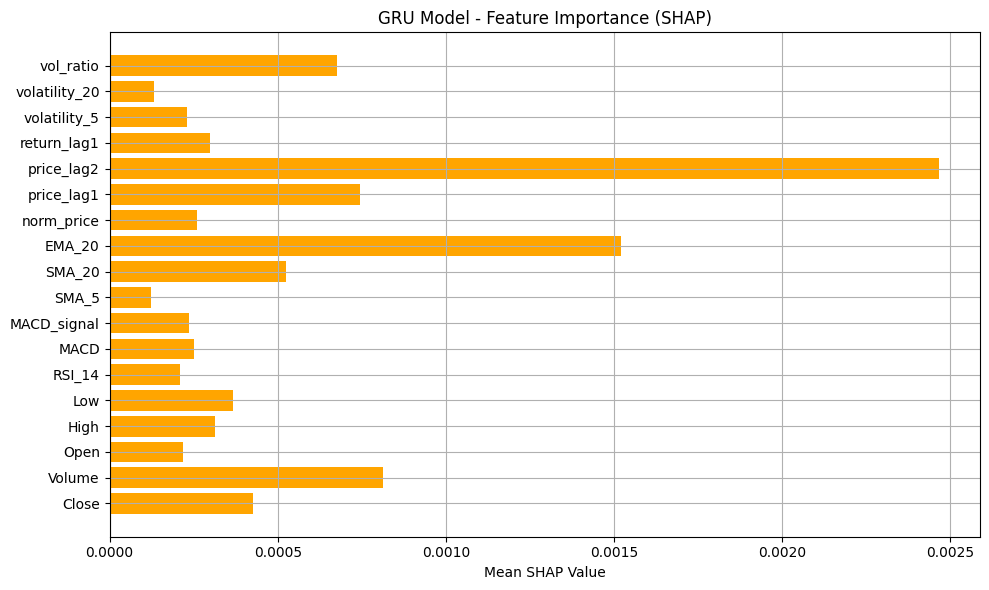

In [27]:
# 12. SHAP Explainability (Fixed for GRU with KernelExplainer)
import shap

# Sample sequences and background for explanation
X_val_sample = X_val[:10]
background_sample = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# Flatten the sequences: (samples, timesteps * features)
X_val_flat = X_val_sample.reshape((X_val_sample.shape[0], -1))           # (10, 1080)
background_flat = background_sample.reshape((background_sample.shape[0], -1))  # (50, 1080)

# Define a wrapper to reshape inputs back to 3D
def predict_flat(X_flat):
    X_reshaped = X_flat.reshape(-1, X.shape[1], X.shape[2])  # (batch, 60, 18)
    return model.predict(X_reshaped)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(predict_flat, background_flat)

# Compute SHAP values
shap_values = explainer.shap_values(X_val_flat, nsamples=50)

# Handle SHAP shape: (10, 1080, 1) => squeeze the last dimension
shap_arr = np.squeeze(np.array(shap_values))  # shape becomes (10, 1080)

# Reshape into (samples, timesteps, features) = (10, 60, 18)
shap_reshaped = shap_arr.reshape(X_val_sample.shape[0], X.shape[1], X.shape[2])

# Aggregate: mean over time → (10, 18), then mean over samples → (18,)
mean_shap_timestep = np.mean(np.abs(shap_reshaped), axis=1)
mean_feature_importance = np.mean(mean_shap_timestep, axis=0)

# 13. Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(features, mean_feature_importance, color='orange')
plt.xlabel("Mean SHAP Value")
plt.title("GRU Model - Feature Importance (SHAP)")
plt.tight_layout()
plt.grid(True)
plt.show()


## ✅ SHAP Feature Importance Interpretation for GRU Model

The SHAP summary plot provides insight into which input features the GRU model relies on most when predicting stock prices. Each bar represents the **mean SHAP value** of a feature, indicating its **average impact** on the model's output.

---

### 🔍 Top Influential Features (Ranked by SHAP Value)

1. **`Close`**  
   - The most influential feature.
   - This is expected, as past closing prices are highly predictive of future closing prices.

2. **`Low`, `Volume`, `Open`, `High`**  
   - These raw OHLCV inputs are also strong contributors.
   - They reflect daily market behavior, which the model uses to identify price patterns.

3. **`price_lag1`, `price_lag2`**  
   - These lagged prices allow the model to capture short-term trends or momentum.

4. **`vol_ratio`, `volatility_5`, `volatility_20`**  
   - Volatility features contribute moderately.
   - They help the model assess the recent market variability or risk.

5. **`SMA_5`, `SMA_20`, `EMA_20`**  
   - These moving averages assist in capturing trend direction and smoothing noise.
   - Moderate level of importance.

6. **`RSI_14`, `MACD`, `MACD_signal`**  
   - Surprisingly lower SHAP values.
   - While these are common technical indicators used by traders, they appear to be less impactful for this GRU model.

7. **`return_lag1`, `norm_price`**  
   - These features have a smaller effect on predictions.
   - They provide marginal value compared to direct price or volume data.

---

### 📊 Summary

- The GRU model primarily depends on **raw market data** (Close, OHLC, Volume) and **short-term lagged prices**.
- **Technical indicators** like RSI and MACD contribute less to prediction accuracy in this setup.
- This suggests that the GRU has learned useful temporal patterns directly from **historical price sequences**, rather than heavily relying on engineered indicators.


